In [1]:
import os, sys
%matplotlib inline

In [2]:
sys.path.append('../app_paria')

In [3]:
from utils_data.data_prep import load_data_clean, data_preparation, creation_features, transform_data

In [4]:
usecols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
urls = ['https://www.football-data.co.uk/mmz4281/{}{}/F1.csv'.format(i,i+1) for i in range(15, 20)]

In [5]:
df, teams = load_data_clean(urls, usecols)

In [6]:
df = data_preparation(df)

In [7]:
df_1 = creation_features(df)

In [8]:
df_1.columns

Index(['Date', 'Home/Away', 'Team_y', 'Opponent', 'final_result', 'scoret_w_x',
       'scoret_d_x', 'scoret_l_x', 'scoret_w_y', 'scoret_d_y',
       ...
       'R_Opp_Opponent_3', 'R_Opp_Opponent_4', 'R_Opp_Opponent_5',
       'final_result_Opponent_1', 'final_result_Opponent_2',
       'final_result_Opponent_3', 'final_result_Opponent_4',
       'final_result_Opponent_5', 'Year', 'Month'],
      dtype='object', length=163)

In [173]:
f = lambda x: teams[x]
df[["Team", "Opponent"]] = df[["Team", "Opponent"]].applymap(f)

KeyError: "['Team'] not in index"

In [25]:
df.columns

Index(['Date', 'Home/Away', 'Team', 'Opponent', 'FTG', 'FTG_Opp', 'S', 'S_Opp',
       'ST', 'ST_Opp', 'F', 'F_Opp', 'C', 'C_Opp', 'Y', 'Y_Opp', 'R', 'R_Opp',
       'final_result'],
      dtype='object')

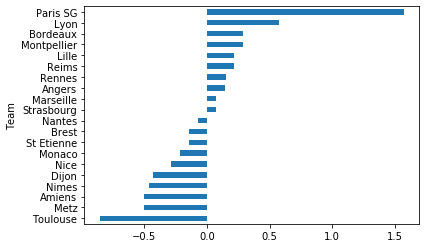

In [88]:
var = 'FTG'
df.groupby('Team')[var, var+'_Opp'].mean().apply(lambda x: x[var] - x[var+'_Opp'], axis=1).sort_values().plot.barh()

In [114]:
score_rslt = lambda x: 1 if x is 'W' else 0.5 if x is 'D' else 0

In [40]:
X, y = transform_data(df_1)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [13]:
def train(X, y, model=None, param_grid=None):
    pipe = Pipeline([('model', model)])
    search = GridSearchCV(pipe, param_grid, iid=True, cv=5, n_jobs=-1)
    search.fit(X, y)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    return search

In [41]:
X.drop(columns=["Home/Away","scoret_w_x","scoret_d_x","scoret_l_x","scoret_w_y","scoret_d_y","scoret_l_y"], inplace=True)

In [42]:
rf = RandomForestClassifier(class_weight='balanced',random_state=1)
param_grid = {
    'model__n_estimators':[70, 80, 90],
    'model__max_depth':[16, 32, 64],
    'model__min_samples_leaf':[3, 6, 9, 12],
}
model = train(X, y, model=rf, param_grid=param_grid)

Best parameter (CV score=0.435):
{'model__max_depth': 16, 'model__min_samples_leaf': 3, 'model__n_estimators': 90}


In [28]:
pred_proba = model.predict_proba(X)

In [29]:
model.classes_

array(['D', 'L', 'W'], dtype=object)

## Interpretation

In [76]:
from sklearn.linear_model import RidgeClassifierCV

In [73]:
# first interpret drawback
y_draw = pred_proba[:,2]

In [80]:
reg = RidgeClassifierCV(cv=5, normalize=True, class_weight='balanced').fit(X, y)

C:\Users\micka\Anaconda3\envs\data_science\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
C:\Users\micka\Anaconda3\envs\data_science\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' u

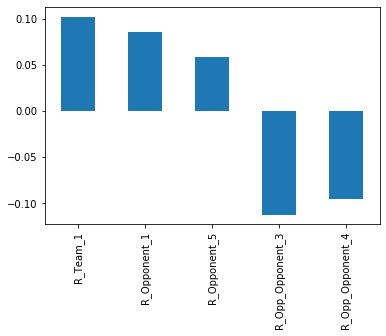

In [92]:
cl_target = 2
(reg.coef_[cl_target]/X.std())[abs(reg.coef_[cl_target]/X.std()) >= 0.05].plot.bar()